In [88]:
import pandas as pd
import numpy as np
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [49]:
VECTOR_DB_PATH = "../../../data/vectorDB/disease_context_chromaDB_using_all_MiniLM_L6_v2_sentence_transformer_model_with_chunk_size_3000"
SENTENCE_EMBEDDING_MODEL = "all-MiniLM-L6-v2"

VALIDATION_DATA_PATH = "../../../data/validation_questions_for_retrieval_performance.csv"
TEST_DATA_PATH = "../../../data/test_questions_for_retrieval_performance.csv"

SAVE_DATA_PATH = "../../../data"

SAVE_RETRIEVAL_SCORE_PATH = os.path.join(SAVE_DATA_PATH, 
                                         "retrieval_thresh_score_for_{}.csv".format("_".join(SENTENCE_EMBEDDING_MODEL.split("-"))))

MAX_SEARCH = 10000


In [4]:
validation_data = pd.read_csv(VALIDATION_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)


In [6]:
validation_data.head()


,questions,questions_as_in_database,predicate
0,pancreatic cancer localizes Anatomy common hep...,pancreatic cancer LOCALIZES Anatomy common hep...,LOCALIZES
1,cardiac arrest presents Symptom Hyperventilation,cardiac arrest PRESENTS Symptom Hyperventilation,PRESENTS
2,anemia localizes Anatomy colostrum,anemia LOCALIZES Anatomy colostrum,LOCALIZES
3,Compound Rosuvastatin treats prostate cancer,Compound Rosuvastatin TREATS prostate cancer,TREATS
4,prostate cancer localizes Anatomy epithelium,prostate cancer LOCALIZES Anatomy epithelium,LOCALIZES


In [7]:
embedding_function = SentenceTransformerEmbeddings(model_name=SENTENCE_EMBEDDING_MODEL)

vectorstore = Chroma(persist_directory=VECTOR_DB_PATH, 
                     embedding_function=embedding_function)


/Users/karthiksoman/anaconda3/envs/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [112]:
%%time

total_validation_data = validation_data.shape[0]
retrieval_score_list = []
for question_id in tqdm(range(total_validation_data)):
    question = validation_data.questions.values[question_id]
    question_in_vectorDB = validation_data.questions_as_in_database.values[question_id]
    search_result = vectorstore.similarity_search_with_score(question, k=MAX_SEARCH)
    for index, item in enumerate(search_result):
        if question_in_vectorDB in item[0].page_content:
            break
    score_range = (search_result[-1][-1]-search_result[0][-1])/(search_result[-1][-1]+search_result[0][-1])
    question_score = (search_result[-1][-1]-search_result[index][-1])/(search_result[-1][-1]+search_result[index][-1])
    retrieval_score_thresh = np.divide(question_score, score_range)
    retrieval_score_list.append((question, retrieval_score_thresh))


100%|███████████████████████████████████████| 1000/1000 [07:54<00:00,  2.11it/s]

CPU times: user 17min 51s, sys: 6min, total: 23min 52s
Wall time: 7min 54s


In [127]:
question_retrieval_score_df = pd.DataFrame(retrieval_score_list, columns=["question", "retrieval_score_thresh"])

# question_retrieval_score_df.to_csv(SAVE_RETRIEVAL_SCORE_PATH, index=False, header=True)
        

In [129]:
question_retrieval_score_df.retrieval_score_thresh.mean()

# print(retrieval_score_thresh_df.retrieval_score_thresh.values)
# np.percentile(question_retrieval_score_df.retrieval_score_thresh.values, 40)

0.7131404246968357

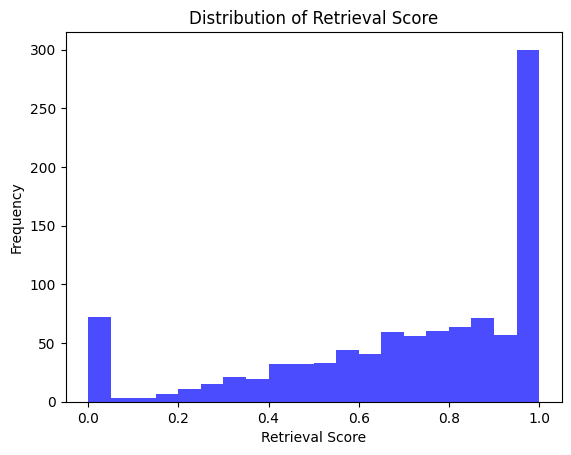

In [130]:

question_retrieval_score = question_retrieval_score_df['retrieval_score_thresh']

plt.hist(question_retrieval_score, bins=20, color='blue', alpha=0.7)

plt.xlabel('Retrieval Score')
plt.ylabel('Frequency')

plt.title('Distribution of Retrieval Score')

plt.show()


In [131]:
question_retrieval_score_df[question_retrieval_score_df.retrieval_score_thresh > 0.7].shape


(608, 2)

In [135]:
question_retrieval_score_array = question_retrieval_score_df.retrieval_score_thresh.unique()
question_retrieval_score_df.sort_values(by="retrieval_score_thresh", inplace=True)

retrieval_score = []
for item in question_retrieval_score_array:
    retreived_df = question_retrieval_score_df[question_retrieval_score_df.retrieval_score_thresh >= item]
    retrieval_score.append((item, np.divide(retreived_df.shape[0], total_validation_data)))
    
retrieval_score_df = pd.DataFrame(retrieval_score, columns=["retrieval_score_thresh", "retrieval_score"])


In [136]:
retrieval_score_df

,retrieval_score_thresh,retrieval_score
0,0.000000,1.000
1,0.027023,0.930
2,0.036493,0.929
3,0.070115,0.928
4,0.080258,0.927
...,...,...
685,0.996003,0.246
686,0.997299,0.245
687,0.998147,0.244
688,0.998714,0.243


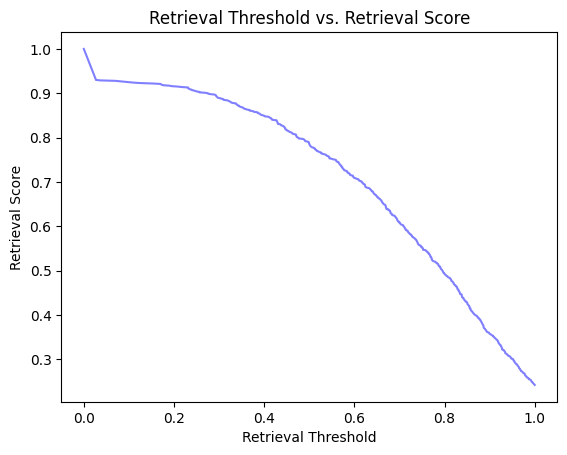

In [138]:
retrieval_score_thresh = retrieval_score_df['retrieval_score_thresh']
retrieval_score = retrieval_score_df['retrieval_score']

plt.plot(retrieval_score_thresh, retrieval_score, color='b', alpha=0.5)

plt.xlabel('Retrieval Threshold')
plt.ylabel('Retrieval Score')


plt.title('Retrieval Threshold vs. Retrieval Score')

plt.show()

In [ ]:
# A good retrieval threshold should should have high retrieval score and retrieve less documents.


In [51]:
# question_id = 5
# question = validation_data.questions.values[question_id]
# question_in_vectorDB = validation_data.questions_as_in_database.values[question_id]
# search_result = vectorstore.similarity_search_with_score(question, k=10000)

# for index, item in enumerate(search_result):
# 	if question_in_vectorDB in item[0].page_content:
# 		break

# score_range = (search_result[-1][-1]-search_result[0][-1])/(search_result[-1][-1]+search_result[0][-1])
# question_score = (search_result[-1][-1]-search_result[index][-1])/(search_result[-1][-1]+search_result[index][-1])
# retrieval_score_thresh = np.divide(question_score, score_range)